# Impor Modul

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Buat Data Aktual

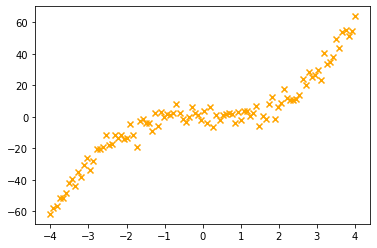

In [ ]:
def generate_dataset(a, b, n, deg):
    X = np.linspace(a, b, n)
    y = np.zeros(n)
    for i in range(n):
        y[i] += X[i]**deg + np.random.normal(0, 1/2*(b-a))
    return X, y


def plot_dataset(X, y):
    plt.scatter(X, y, marker='x', c='orange')
    plt.show()


a = -4
b = 4
n = 100
deg = 3
X, y = generate_dataset(a, b, n, deg)
plot_dataset(X, y)

# Definisi Permasalahan

1. Mencari polinomial berderajat $n$ yang paling cocok dengan datapoints Polinomial yang dicari dibatasi maksimal berderajat `max_degree`. <br>
$P_n(x) = a_0 + a_1x + a_2x^2 + \dots + a_{n-1}x^{n-1} + a_n x^n,\ n \leq$ `max_degree`
1. Kromosom direpresentasikan sebagai vektor koefisien <br>
$\mathbf{X}^{(j)} = (\mathbf{X}_1^{(j)}, \mathbf{X}_2^{(j)}, \dots, \mathbf{X}_k^{(j)}),\ j=1,2, \dots, g$ <br>
$\mathbf{X}_i^{(j)} = (a_0, a_1, a_2, \dots, a_{n-1}, a_n),\ n \leq$ `max_degree`
1. Fungsi fitnes yang dipakai adalah _root mean squared error_ (RMSE). <br>
$f = \displaystyle\sqrt{\sum_{i=1}^m \frac{(\hat{y}_i - y)^2}{m}}$

In [ ]:
max_degree = 7

def fitness_function(y, y_pred):
    return np.sqrt(np.mean((y - y_pred)**2))


def individual(max_degree):
    chromosome = np.zeros(max_degree + 1)
    
    degree = np.random.randint(max_degree + 1)
    n = degree + 1

    chromosome[:n] = np.random.randn(n)

    return chromosome


def compute_fitness(chromosome, X, y):
    y_pred = np.polyval(chromosome[::-1], X)
    return fitness_function(y, y_pred)


# Operator GA

## Selection

In [ ]:
def selection(pop, elitism=None):
    if elitism == None:
        elitism = 0

    n_pop = pop.shape[0]
    n_var = pop.shape[-1] - 1

    n_elit = int(elitism * n_pop)
    if n_elit % 2 == 1:  # ganjil
        n_elit += 1
    n_nonelit = int(n_pop/2) - n_elit    

    # Ambil individu-individu elit    
    idx_sort = np.argsort(pop[:,-1])  # Sorting berdasarkan fitness value secara ascending
    pop_sorted = pop[idx_sort]
    pop_elit = pop_sorted[:n_elit, :]

    # Proses seleksi untuk mengambil individu-individu non elit
    pop_nonelit = np.zeros(shape=(n_nonelit, n_var + 1))

    inverse_cost = [1/x[-1] for x in pop]
    total_cost = np.sum(inverse_cost)
    prob_selected = inverse_cost / total_cost
    cumsum = np.cumsum(prob_selected)
    
    # for i in range(nselected):    
    for i in range(n_nonelit):
        r = np.random.rand()
        if r <= cumsum[0]:
            # selected[i, 1:nvar+1] = pop[1, 1:nvar + 1 + 1]
            pop_nonelit[i, 1:n_var+1] = pop[1, 1:n_var + 1 + 1]
        for j in range(1, n_pop):
            if r <= cumsum[j] and r > cumsum[j-1]:
                # selected[i, 1:nvar+1] = pop[j, 1:nvar + 1 + 1]
                pop_nonelit[i, 1:n_var+1] = pop[j, 1:n_var + 1 + 1]
    
    # return selected
    return pop_elit, pop_nonelit


## Crossover

In [ ]:
def crossover(pop_elit, pop_nonelit, crossrate):
    n_elit = pop_elit.shape[0]
    n_nonelit = pop_nonelit.shape[0]
    n_var = pop_nonelit.shape[-1] -1

    n_pop_nonelit = 2 * (n_elit + n_nonelit) - n_elit
    new_gen_nonelit = np.zeros(shape=(n_pop_nonelit, n_var + 1))

    for i in range(0, n_pop_nonelit, 2):
        # Mengambil 2 parent secara acak
        idx = np.random.permutation(n_nonelit)
        parent1 = pop_nonelit[idx[0], :n_var]
        parent2 = pop_nonelit[idx[1], :n_var]

        do_crossover = np.random.rand() < crossrate
        if do_crossover:
            gamma = 0;
            alpha = np.random.uniform(-gamma, 1+gamma, n_var)

            child1 = alpha * parent1 + (1-alpha) * parent2;
            child2 = alpha * parent2 + (1-alpha) * parent1;

            new_gen_nonelit[i, :n_var] = child1
            new_gen_nonelit[i+1, :n_var] = child2

        else:
            new_gen_nonelit[i, :n_var] = parent1
            new_gen_nonelit[i+1, :n_var] = parent2

    return new_gen_nonelit


## Mutation

In [ ]:
def mutation(new_gen_nonelit, mutation_rate):
    npop = new_gen_nonelit.shape[0]
    nvar = new_gen_nonelit.shape[-1] - 1

    mutated = np.copy(new_gen_nonelit)

    for i in range(npop):
        do_mutation = np.random.rand() < mutation_rate
        if do_mutation:
            j = np.random.randint(nvar)  # Posisi gen yang akan dimutasi
            new_gen_nonelit[i, j] = new_gen_nonelit[i, j] + 10 * np.random.randn()

    return mutated


## Recompute Fitness Value

In [ ]:
def mutated_fitness(mutated_nonelit, X, y):
    npop = mutated_nonelit.shape[0]
    nvar = mutated_nonelit.shape[-1] -1

    for i in range(npop):
        mutated_nonelit[i, -1] = compute_fitness(mutated_nonelit[i, :nvar], X, y)
    
    return mutated_nonelit


# Main

In [ ]:
def generate_pop(npop, max_degree, X, y):
    pop = np.zeros(shape=(npop, max_degree + 1 + 1))  # +1 terakhir untuk menaruh nilai fitnes
    for i in range(npop):
        pop[i, :max_degree + 1] = individual(max_degree)
        pop[i, -1] = compute_fitness(pop[i, :max_degree + 1 + 1], X, y)
    return pop


In [ ]:
def ga_curve_fitting(max_degree, X, y, npop, ngen, elitism=0.1, crossrate=0.8, mutation_rate=0.05):
    pop = generate_pop(npop, max_degree, X, y)  # Generate populasi awal

    fitness_history = np.zeros(ngen)

    for i in range(ngen):
        pop_elit, pop_nonelit = selection(pop, elitism)
        new_gen_nonelit = crossover(pop_elit, pop_nonelit, crossrate)
        mutated_nonelit = mutation(new_gen_nonelit, mutation_rate)
        new_pop_nonelit = mutated_fitness(mutated_nonelit, X, y)

        pop = np.vstack([pop_elit, new_pop_nonelit])

        idx_best = np.argmin(pop[:, -1])
        fitness_history[i] = pop[idx_best, -1]

        if i % 10 == 9:
            print(f'Generation {i+1}, fitness = {pop[idx_best, -1]}')

    solution = pop[idx_best, :-1]
    fitness_value = pop[idx_best, -1]

    return solution, fitness_value, fitness_history

In [ ]:
n_pop = 100
n_gen = 100

solution, fitness_value, fitness_history = ga_curve_fitting(max_degree, X, y, n_pop, n_gen)

Generation 10, fitness = 3.9684097210852047
Generation 20, fitness = 3.9602032416347446
Generation 30, fitness = 3.9589929159147705
Generation 40, fitness = 3.958938115550569
Generation 50, fitness = 3.958938115550569
Generation 60, fitness = 3.958938115550569
Generation 70, fitness = 3.958938115550569
Generation 80, fitness = 3.958938115550569
Generation 90, fitness = 3.958938115550569
Generation 100, fitness = 3.958938115550569


Text(0, 0.5, 'RMSE')

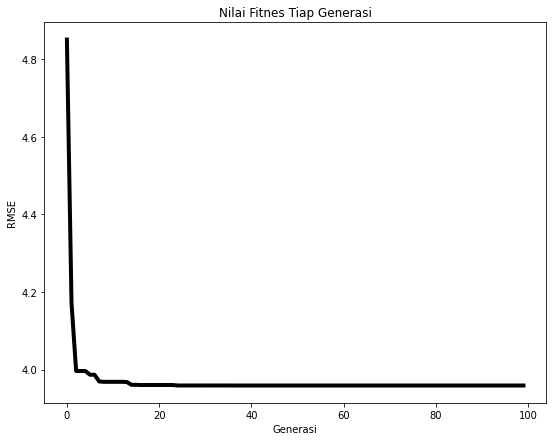

In [ ]:
fig, ax = plt.subplots(figsize=(9, 7))
ax.plot(fitness_history, c='black', linewidth=4)
plt.title('Nilai Fitnes Tiap Generasi')
plt.xlabel('Generasi')
plt.ylabel('RMSE')

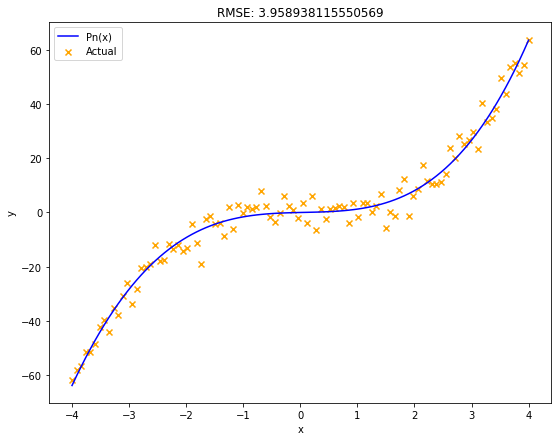

In [ ]:
y_pred = np.polyval(solution[::-1], X)

fig, ax = plt.subplots(figsize=(9, 7))
ax.scatter(X, y, marker='x', c='orange', label='Actual')
ax.plot(X, y_pred, c='blue', label='Pn(x)')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.title(f'RMSE: {fitness_value}')
plt.legend()
plt.show()